# Get data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from matplotlib import colors
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import keras_tuner
import keras
from tensorflow.keras import layers

2023-11-06 19:16:19.453758: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 19:16:19.453859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 19:16:19.461675: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 19:16:21.076760: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [2]:


dataDir = "/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
# dataFiles=['female_1.mat']

data = [] #processed and normalised with pose_idx
e = 2.718281828459045

def normalize_arr(arr,i):
    signal = arr.copy()
    # signal = e**signal
    # signal /= np.sum(signal)
    # signal = np.clip(signal,1e-7,1e+7)
    signal = signal.tolist()
    signal.append(int(i/2))
    signal = np.array(signal)
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    # label = list((np.array(chn1).T)[-1].T.astype(int))
    label = int(i/2)
    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))
    # print(np.array(chn1).shape)
    # print(label)
    # print('label[i]: ',label[i])
    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data



for file in dataFiles:
    data_path = dataDir+file
    print(data_path)
    mat = scipy.io.loadmat(data_path)
    mat.pop("__header__")
    mat.pop("__version__")
    mat.pop("__globals__")
    i=0

    plot_interval = 100
    plot_index = 0

    for channel in mat: 
       
        if(i%2==0):
            channel2 =  channel[:-1]
            channel2 += '2'
            sigs1 = mat[channel] 
            sigs2 = mat[channel2]
            sigs1_norm = []
            sigs2_norm = []

            for signal in sigs1:
                # signal = normalize_arr(signal,i)
                if(signal[0]<2):
                    sigs1_norm.append(signal)
            for signal in sigs2:
                # signal = normalize_arr(signal,i)
                if(signal[0]<2):
                    sigs2_norm.append(signal)
            if i==0:
                data = get_channel_pair(sigs1_norm,sigs2_norm,i)
            else:
                None
                data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                data += data_lc
        i+=1

print(np.array(data).shape)
print(data[-3])





/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/female_1.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/female_2.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/female_3.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/male_1.mat
/media/james/Datasets_Drive1/semg_for_basic_hand_movment_6/Database_1/male_2.mat
(539820, 3)
[-0.029808, 0.125662, 5]


In [3]:
import pandas as pd
import math  
def reshape_data(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    time = 0
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        tmp = reshape_data.tolist()
        tmp.append(int(label[i]))
        tmp = np.array(tmp)

        if(len(reshape_data)==n*2):
            newShape_data.append(tmp)
        i += n
        time += 1

    newShape_data = np.array(newShape_data)
    return newShape_data

def split_X(arr):
    arr = arr.T
    arr = arr[0:-1]
    arr = arr.T
    return arr
def split_y(arr):
    arr = arr.T
    arr = arr[-1]
    arr = arr.T.astype(np.uint8)
    return arr
def reshape_arr(arr):
    new_shape = []
    for row in arr:
        n_len =int(math.sqrt(len(row)))
        row = row.reshape(n_len,n_len)
        new_shape.append(row)
    return np.array(new_shape)
def reshape_arr_img_transfer(arr,n):
    new_shape = []
    for row in arr:
        n_len = len(row)
        row =np.pad(row,(0,n-n_len),'constant')
        row = row.reshape(n,n)
        new_shape.append(row)
    return np.array(new_shape)

# print(df)
dataset = data.copy()
df = pd.DataFrame(dataset, columns = ['channel1','channel2','label'])
mask = np.random.rand(len(df)) < 0.8
dataset_t_v = df[mask] #test & val
dataset_test = df[~mask]

val_test_mask = np.random.rand(len(dataset_t_v)) < 0.5
dataset_train = dataset_t_v[val_test_mask]
dataset_val = dataset_t_v[~val_test_mask]
# n=392

n=1458
dataset_train_ar = reshape_data(n,dataset_train)
dataset_test_ar = reshape_data(n,dataset_test)
dataset_val_ar = reshape_data(n,dataset_val)
print(dataset_train_ar[-20:][-1])

np.random.shuffle(dataset_train_ar)
np.random.shuffle(dataset_test_ar)
np.random.shuffle(dataset_val_ar)

print(dataset_train_ar[-20:][-1])

X = split_X(dataset_train_ar)
y = split_y(dataset_train_ar)


X_val = split_X(dataset_train_ar)
y_val = split_y(dataset_train_ar)

X_test = split_X(dataset_test_ar)
y_test = split_y(dataset_test_ar)


# OPTIONAL TURN X TO NxN
# X = reshape_arr(X)
# X_val = reshape_arr(X_val)
# X_test = reshape_arr(X_test)

# OPTIONAL TURN X TO NxN | N>= 150 transfer learning
tuple_size = 150
X_tl = reshape_arr_img_transfer(X,tuple_size)
X_val_tl = reshape_arr_img_transfer(X_val,tuple_size)
X_test_tl = reshape_arr_img_transfer(X_test,tuple_size)

[ 7.21980e-02 -4.30700e-03  2.76211e-01 ...  3.29724e-01  4.91390e-02
  5.00000e+00]
[0.148703 0.148703 0.0977   ... 0.329724 0.176677 2.      ]


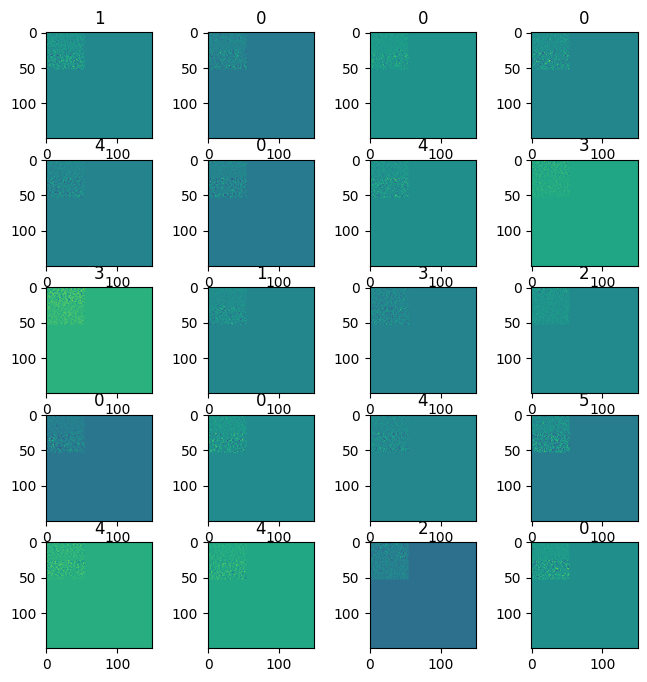

[1 0 0 0 4 0 4 3 3 1 3 2 0 0 4 5 4 4 2 0]


In [4]:
w = 20
h = 20
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    plt.imshow(X_tl[i-1])
plt.show()
print(y[:(columns*rows)])

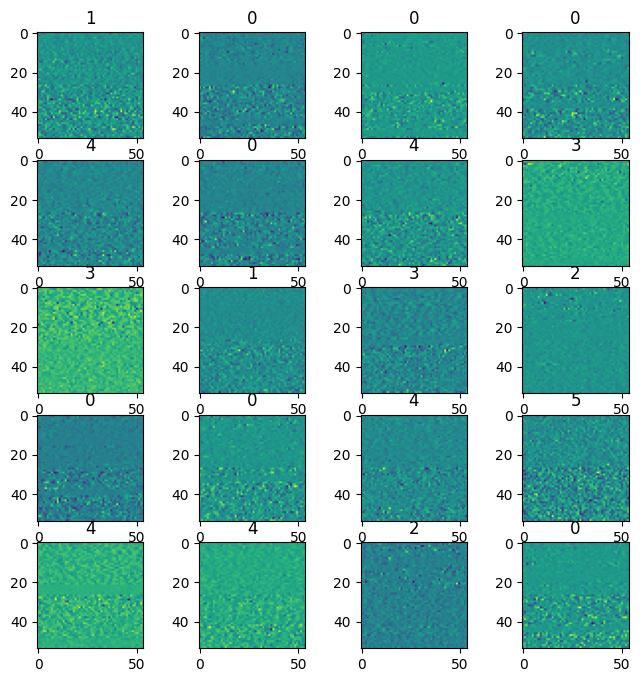

[1 0 0 0 4 0 4 3 3 1 3 2 0 0 4 5 4 4 2 0]


In [5]:
w = 20
h = 20
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.title(y[i-1])
    plt.imshow(X[i-1])
plt.show()
print(y[:(columns*rows)])

In [6]:
dataset_train

,channel1,channel2,label
0,0.021195,0.202185,0
3,0.199706,0.176677,0
8,0.046696,0.253201,0
9,0.072198,0.202185,0
13,0.199706,0.074646,0
...,...,...,...
539811,0.225208,0.610309,5
539814,0.301713,-0.154923,5
539815,0.250710,0.227693,5
539816,-0.055310,0.355232,5


# Transfer Learning
- RESNET50

OPTIONAL TURN X TO NxN | N>= 150 transfer learning
tuple_size = 150
X_tl = reshape_arr_img_transfer(X,tuple_size)
X_val_tl = reshape_arr_img_transfer(X_val,tuple_size)
X_test_tl = reshape_arr_img_transfer(X_test,tuple_size)

In [7]:
print(X[0].shape)
rgb_batch_ts =  np.repeat(X[0][..., np.newaxis], 3, -1)
rgb_batch_ts.shape

(54, 54)


(54, 54, 3)

In [8]:
# def signal_to_3channelimg(arr):
#     print(arr[0].shape)
#     rgb_batch_ts =  np.repeat(arr[..., np.newaxis], 3, -1)
#     rgb_batch_ts.shape
#     return rgb_batch_ts

In [9]:
X_tl = signal_to_3channelimg(X_tl)
X_val_tl = signal_to_3channelimg(X_val_tl)
X_test_tl = signal_to_3channelimg(X_test_tl)

(150, 150)
(150, 150)
(150, 150)


In [10]:
#create basemodel and get it pre-trained para
base_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(150,150,3),
    include_top=False
    )
base_model.trainable = False    

2023-11-06 19:18:07.844634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 19:18:07.878350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 19:18:07.879336: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
inputs = keras.Input(shape=(150, 150, 3))


# x = layers.Rescaling(2)(inputs)
# x = layers.Flatten()(x)
x = base_model(inputs, training=False)

# Apply some convolution and pooling layers
# x = layers.Flatten()(inputs)

x = layers.Dense(2048, activation="relu")(x)
# x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid')
# x = layers.Flatten()(x)
# x = layers.Convolution1D(x,kernel_size=2)
# x = layers.Convolution1D(x)
# input_shape=[5,5,2048]
# x = layers.Conv2D(500, 3, activation='relu', input_shape=input_shape[1:])(x)
x = layers.Conv2D(500, (3,3), activation='relu', input_shape=input_shape[1:])(x)

# x = layers.Conv1D( 1024, 2, activation='relu',input_shape=input_shape[1:])(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(x)
x = layers.Conv1D( 1024, 2, activation='relu',input_shape=input_shape[1:])(x)

# x = layers.Conv2D(200, 3, activation='relu', input_shape=input_shape[1:])(x)
# x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid')(x)

x = layers.Dense(128, activation="relu")(x)

x = keras.layers.GlobalAveragePooling2D()(x)

num_classes = 6

outputs = layers.Dense(num_classes, activation="softmax")(x)

x = layers.Dense(num_classes, activation="softmax")(x)
x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(6)(x)  # Regularize with dropout
model = keras.Model(inputs, outputs)

model.summary()

NameError: name 'input_shape' is not defined

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

epochs = 300
batch_size = 64
history_tl = model.fit(X_tl, y,batch_size=batch_size, epochs=epochs)


Epoch 1/300
3/3 [==============================] - 5s 256ms/step - loss: 8.8544
Epoch 2/300
3/3 [==============================] - 1s 256ms/step - loss: 7.5137
Epoch 3/300
3/3 [==============================] - 1s 256ms/step - loss: 7.3829
Epoch 4/300
3/3 [==============================] - 1s 254ms/step - loss: 7.4874
Epoch 5/300
3/3 [==============================] - 1s 252ms/step - loss: 7.3939
Epoch 6/300
3/3 [==============================] - 1s 250ms/step - loss: 7.1654
Epoch 7/300
3/3 [==============================] - 1s 253ms/step - loss: 7.5823
Epoch 8/300
3/3 [==============================] - 1s 254ms/step - loss: 6.9917
Epoch 9/300
3/3 [==============================] - 1s 255ms/step - loss: 7.7678
Epoch 10/300
3/3 [==============================] - 1s 254ms/step - loss: 7.3571
Epoch 11/300
3/3 [==============================] - 1s 253ms/step - loss: 8.0745
Epoch 12/300
3/3 [==============================] - 1s 255ms/step - loss: 6.9720
Epoch 13/300
3/3 [===================

## visualise training history

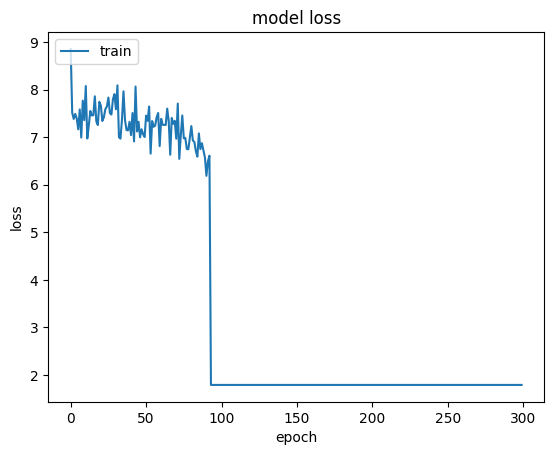

In [ ]:

# summarize history for loss
plt.plot(history_tl.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test_tl,y_test)

1/3 [=========>....................] - ETA: 3s - loss: 1.7918

2023-11-05 22:52:12.114590: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


3/3 [==============================] - 2s 192ms/step - loss: 1.7918


2023-11-05 22:52:12.501385: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1.7917596101760864

## save model ?

In [ ]:
# model.save("./models/model2.keras")

# ALGO
## Random Forest

In [ ]:
import math
import urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf


In [ ]:
dataset_train

,channel1,channel2,label
0,0.021195,0.202185,0
1,0.199706,0.151170,0
3,0.199706,0.176677,0
4,0.250710,0.100154,0
7,0.021195,0.074646,0
...,...,...,...
539806,-0.208320,0.839879,5
539810,0.250710,0.431755,5
539811,0.225208,0.610309,5
539812,0.021195,0.125662,5


In [ ]:
print(dataset_test_ar[0][-1])
column_name =np.array(list(range(n*2+1)))
column_name=column_name+1
column_name=column_name.astype('str')
column_name
us = pd.DataFrame(dataset_test_ar,columns=column_name)

3.0


In [ ]:
us

,1,2,3,4,5,6,7,8,9,10,...,2908,2909,2910,2911,2912,2913,2914,2915,2916,2917
0,-0.055310,-0.616346,-0.539841,-0.208320,0.709739,0.658736,0.505726,-0.361330,0.429221,0.225208,...,-0.231447,0.355232,0.355232,0.584801,0.151170,-0.358985,0.202185,-0.027385,0.227693,3.0
1,-0.004307,0.123201,0.097700,0.225208,0.225208,0.429221,0.072198,0.301713,0.123201,0.250710,...,0.304216,0.176677,-0.410001,-0.154923,0.049139,-0.665078,0.023631,0.457263,0.355232,5.0
2,0.123201,0.072198,0.403719,0.199706,-0.029808,0.148703,-0.106313,0.199706,0.174205,0.199706,...,0.023631,0.074646,0.176677,0.125662,0.329724,0.202185,0.278708,0.074646,0.049139,2.0
3,0.199706,-0.080812,0.301713,0.148703,0.123201,0.046696,0.378218,-0.208320,-0.029808,0.276211,...,0.763355,0.686832,-0.358985,0.253201,-0.282462,0.355232,0.661324,0.355232,0.074646,1.0
4,0.633234,-0.182818,0.250710,-1.381395,0.658736,-0.437835,-0.029808,0.046696,-0.412333,0.097700,...,0.482770,-0.154923,-0.180431,-0.129416,0.151170,0.763355,-0.307970,-0.052892,0.023631,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.352716,1.245273,-0.692851,1.015759,-0.896864,-0.718353,-0.080812,-0.131815,-0.412333,-0.616346,...,0.508278,0.074646,-0.180431,0.457263,0.151170,-0.052892,0.202185,-0.180431,-0.129416,4.0
70,0.046696,0.097700,0.735241,-0.080812,0.072198,0.072198,0.352716,0.352716,0.480224,0.199706,...,0.457263,0.074646,0.253201,0.100154,0.049139,0.661324,0.176677,0.712340,0.329724,0.0
71,-0.386831,-0.208320,-0.055310,0.403719,-0.590844,0.480224,-1.763919,-0.590844,0.505726,0.046696,...,-0.205939,0.074646,0.431755,-0.052892,0.559294,-0.205939,0.686832,0.763355,1.145972,3.0
72,0.378218,-0.157317,-0.233821,0.301713,0.378218,-0.004307,-0.004307,-0.182818,0.250710,0.403719,...,0.304216,0.074646,-0.078400,0.482770,0.839879,0.635817,-0.767109,0.457263,0.176677,1.0


In [ ]:
# # Train a Gradient Boosted Trees model.
# model = tfdf.keras.GradientBoostedTreesModel(num_trees=1500)
lbel_index = n*n
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(us,label=str(n*2+1))

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(verbose=2)

# Train the model.
model_1.fit(train_ds)


Use 12 thread(s) for training
Use /tmp/tmpxsgp8wqf as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'1': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, '2': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, '3': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, '4': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, '5': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, '6': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, '7': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, '8': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, '9': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, '10': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, '11': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, '12': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, '13': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, '14': <tf.Tensor 'data_13:0' shape=(None,) dtype=float64>, '15': <tf.Tensor 'data_14:0' shape=(None,) dtyp

[INFO 23-11-05 22:37:51.6508 +07 kernel.cc:773] Start Yggdrasil model training
[INFO 23-11-05 22:37:51.6508 +07 kernel.cc:774] Collect training examples
[INFO 23-11-05 22:37:51.6508 +07 kernel.cc:787] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 23-11-05 22:37:51.6607 +07 kernel.cc:393] Number of batches: 1
[INFO 23-11-05 22:37:51.6607 +07 kernel.cc:394] Number of examples: 74
[INFO 23-11-05 22:37:51.6668 +07 kernel.cc:794] Training dataset:
Number of records: 74
Number of columns: 2917

Number of columns by type:
	NUMERICAL: 2916 (99.9657%)
	CATEGORICAL: 1 (0.0342818%)

Columns:

NUMERICAL: 2916 (99.9657%)
	0: "1" NUMERICAL mean:0.135952 min:-0.896864 max:1.

Model trained in 0:00:01.389891
Compiling model...
Model compiled.


In [ ]:
model_1.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2916):
	1
	10
	100
	1000
	1001
	1002
	1003
	1004
	1005
	1006
	1007
	1008
	1009
	101
	1010
	1011
	1012
	1013
	1014
	1015
	1016
	1017
	1018
	1019
	102
	1020
	1021
	1022
	1023
	1024
	1025
	1026
	1027
	1028
	1029
	103
	1030
	1031
	1032
	1033
	1034
	1035
	1036
	1037
	1038
	1039
	104
	1040
	1041
	1042
	1043
	1044
	1045
	1046
	1047
	1048
	1049
	105
	1050
	1051
	1052
	1053
	1054
	1055
	1056
	1057
	1058
	1059
	106
	1060
	1061
	1062
	1063
	1064
	1065
	1066
	1067
	1068
	1069
	107
	1070
	1071
	1072
	1073
	1074
	1075
	1076
	1077
	1078
	1079
	108
	1080
	1081
	1082
	1083
	1084
	1085
	1086
	1087
	1088
	1089
	

# Bluetooth <placeholder>

In [ ]:
import bluetooth

nearby_devices = bluetooth.discover_devices(lookup_names=True)
print("Found {} devices.".format(len(nearby_devices)))

for addr, name in nearby_devices:
    print("  {} - {}".format(addr, name))

ModuleNotFoundError: No module named 'bluetooth'